In [25]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import geopandas as gpd 
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box

labelsize_small  = 13
labelsize_medium = 15
labelsize_large  = 17

#### Step 1: Load and Prepare Data 

In [26]:
# loading & preparing gdp data
gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2']]
gdp_df.loc[gdp_df.scen == 'Ref1p5', 'scen'] = 'Ref'
# only keep data for year that we are interested in: 
gdp_baseline = gdp_df[gdp_df.year == 2015]['SSP2'].values
gdp_df   = gdp_df[(gdp_df.year == cset.gdp_target_year)].copy()
# adding for compatibility with characteristics df s
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)

# loading & preparing tas_baseline data
tas_df = pd.read_csv(cset.file_tas)
tas_df = tas_df[tas_df.year == 2015].copy()
tas_df = tas_df.rename(columns = {'run': 'scen_run', 'tas': 'tas_soc'})
tas_df = tas_df.dropna(subset=['tas_soc']).groupby('iso').filter(lambda x: x['tas_soc'].notna().all())
tas_df.loc[tas_df['scen_run'].str.contains('Ref_1p5'), 'scen_run'] = tas_df['scen_run'].str.replace('Ref_1p5', 'Ref')

# loading & preparing glmt data 
glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, 'gmt_characteristics_thsld_150.csv'), index_col = 0)

# merge datasets into a single regression dataset
regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
regression_df['GDP_baseline'] = gdp_baseline
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
#   - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df['tas_soc']      -= regression_df['tas_baseline']
regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
regression_df['gmt_os']       = regression_df['gmt_max']- regression_df['gmt_eoc']
regression_df['log_gmt_cum']  = np.log(regression_df['gmt_cum'])
regression_df['gmt_delta_eoc'] = 1.5+regression_df['gmt_exc']*2-regression_df['gmt_eoc']
regression_df['gmt_delta_max'] = regression_df['gmt_max']-(1.5+2*regression_df['gmt_eoc'])
# clear storage
# del gdp_df, glmt_char_df, tas_df

In [27]:
# better target variable compared to regression_df['diff_SSP2']
y = np.log(regression_df['diff_SSP2'])

# Define predictor variables (excluding 'iso' and the target variable)
predictors = ['tas_soc', 'tas_baseline', 'gmt_cum', 'gmt_max', 'gmt_eoc', 'gmt_os', 'gmt_od', 'log_gmt_cum', 'gmt_exc', 'gmt_delta_eoc', 'gmt_delta_max', 'gmt_uxc']
# Generate second-order terms
poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])
X_poly_std = StandardScaler().fit_transform(X_poly)
# Extract polynomial feature names
poly_feature_names  = poly.get_feature_names_out(predictors)
predictor_df        = pd.DataFrame(X_poly_std, columns = poly_feature_names)
regression_df.index = predictor_df.index
# interactions with tas_baseline 
interaction_terms   = [f for f in poly_feature_names if ('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')]

# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list([f+'^2' for f in predictors])
# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1

#### Step 2: Quantify effect of every increment in exceedance of 1.5°C

In [ ]:
# we want to single out the effect of gmt_exc --> need to correct for other gmt-related variables 


#### Step 2: fit RF for each country seperately 

##### a: Exploring all predictors 

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


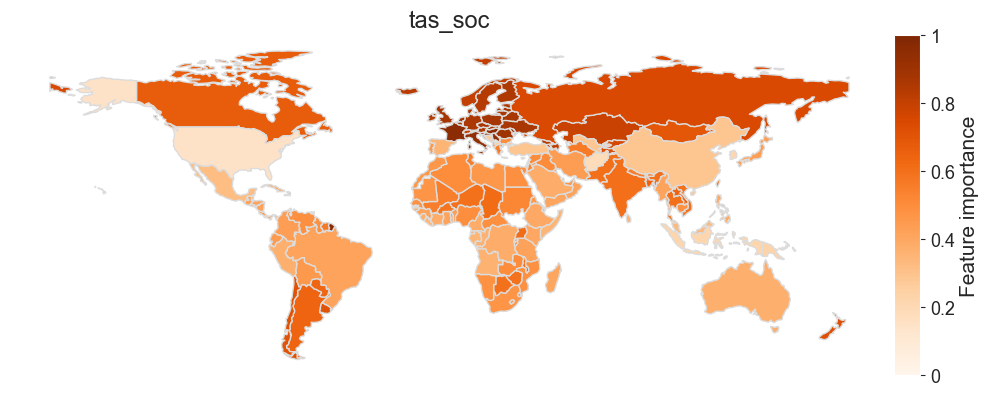

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


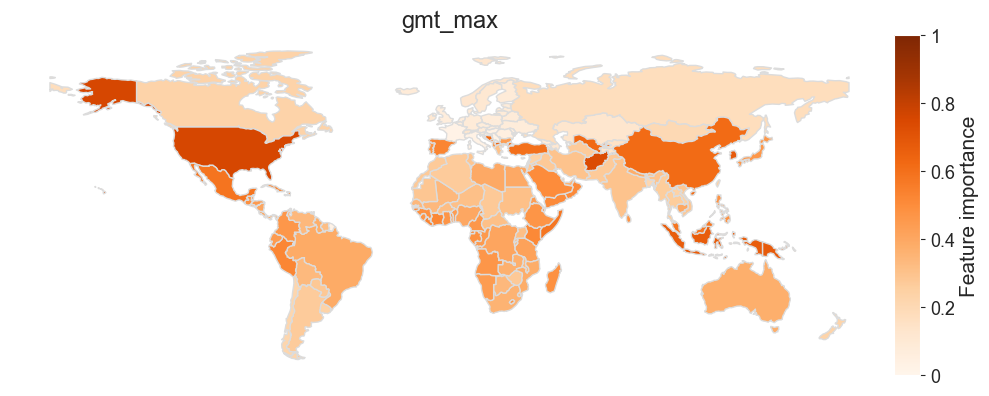

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


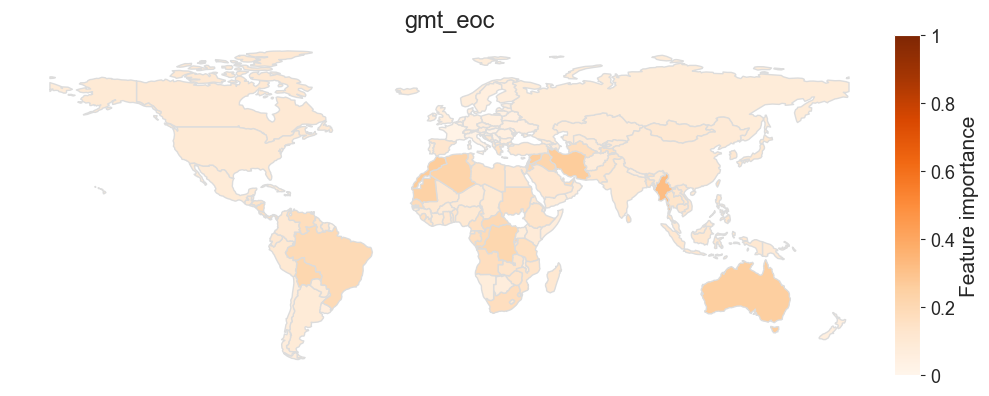

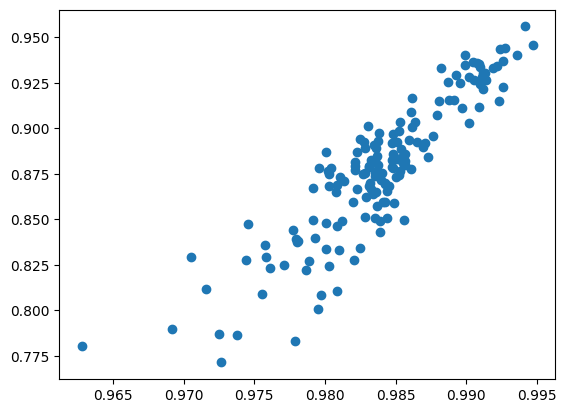

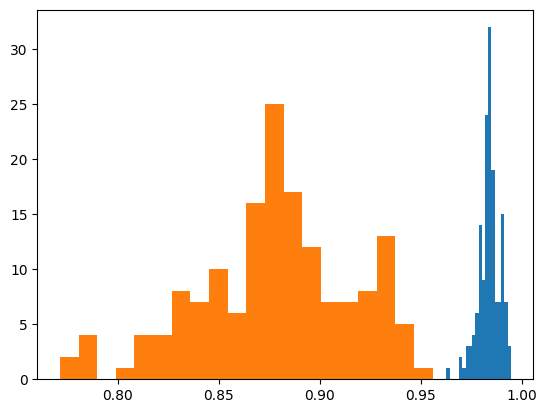

In [28]:
sel_predictors = ['tas_soc', 'gmt_max', 'gmt_eoc']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries, dtype = float) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
# plt.plot([0,1], [0,1], color = 'C1')
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


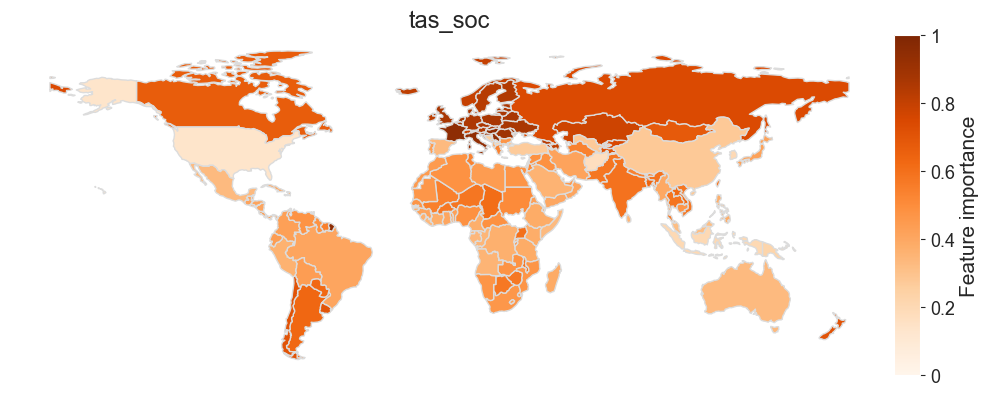

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


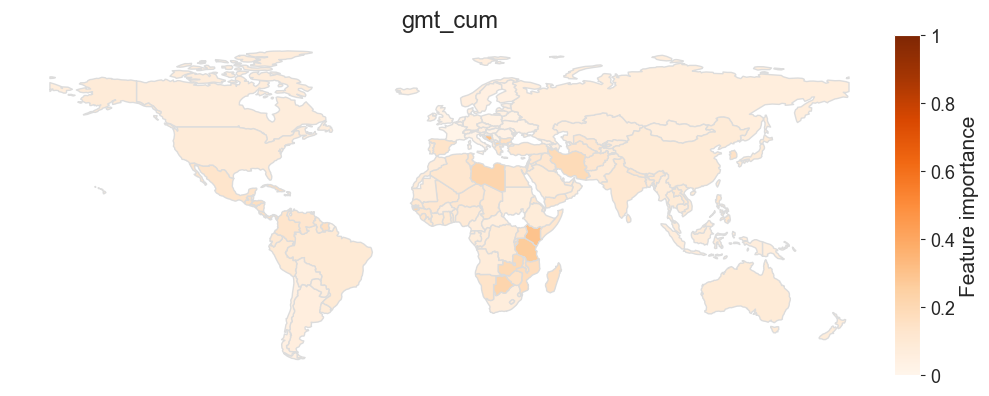

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


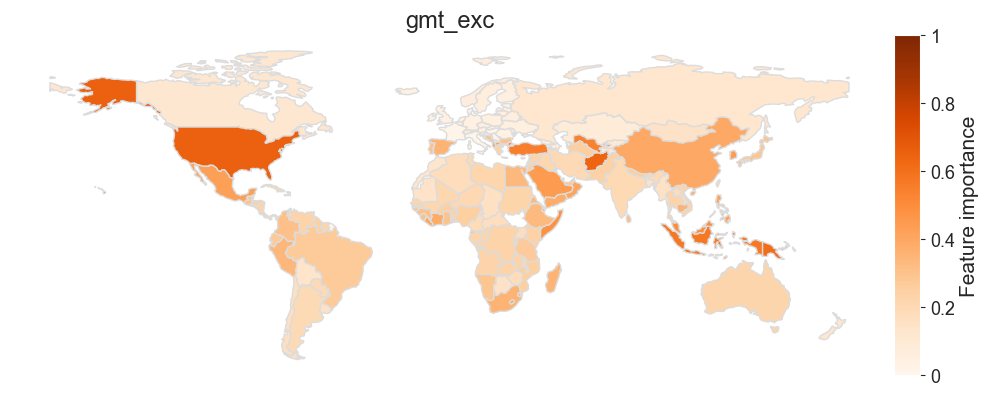

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


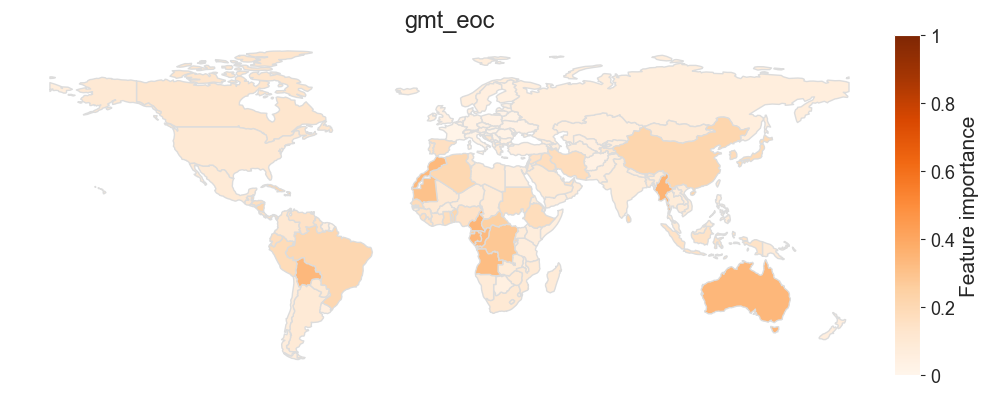

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


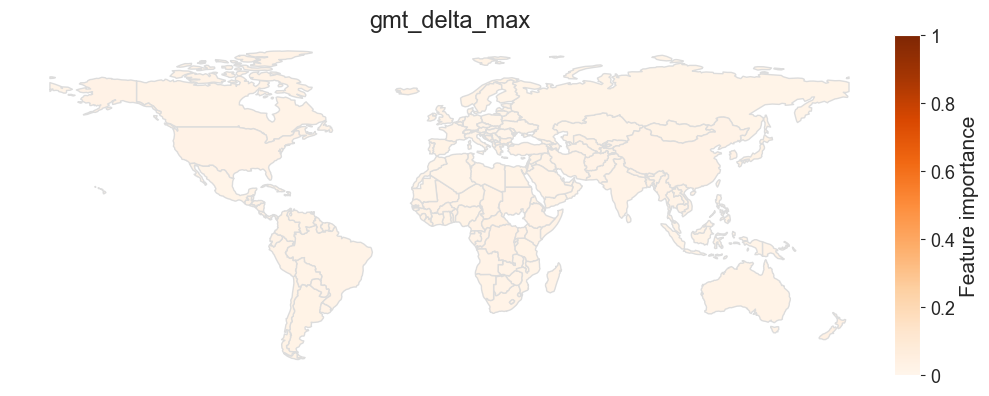

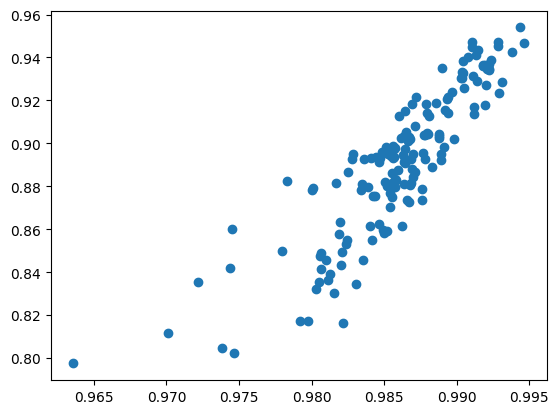

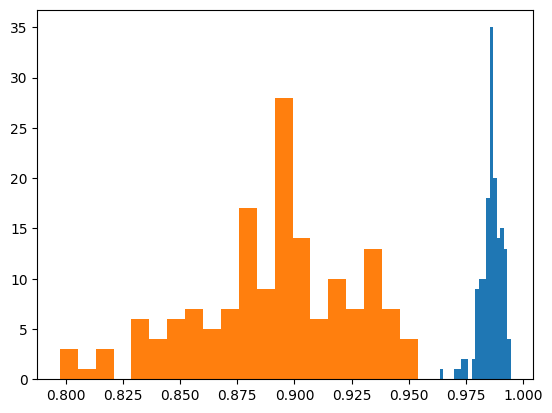

In [29]:
sel_predictors = ['tas_soc', 'gmt_cum', 'gmt_exc', 'gmt_eoc', 'gmt_delta_max']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries, dtype = float) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
# plt.plot([0,1], [0,1], color = 'C1')
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

#### b: Expploring variations 

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


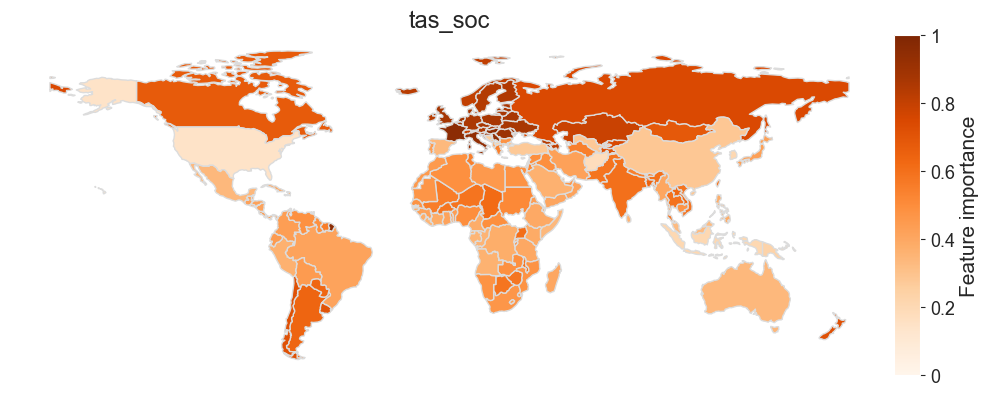

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


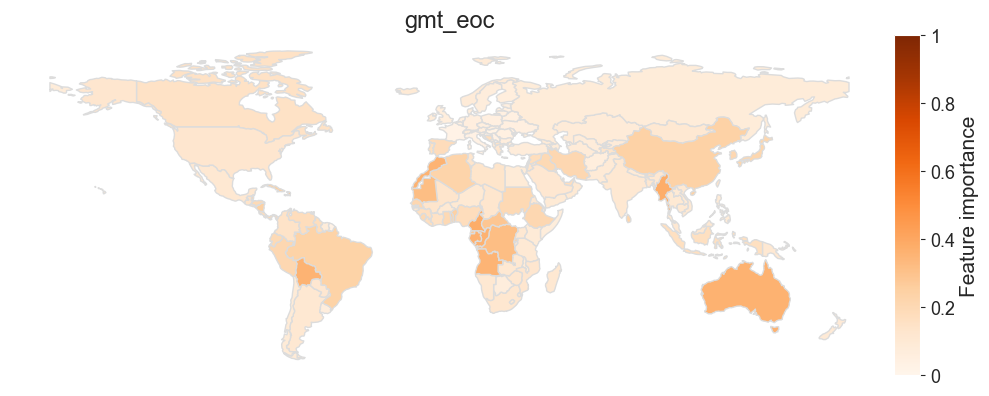

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


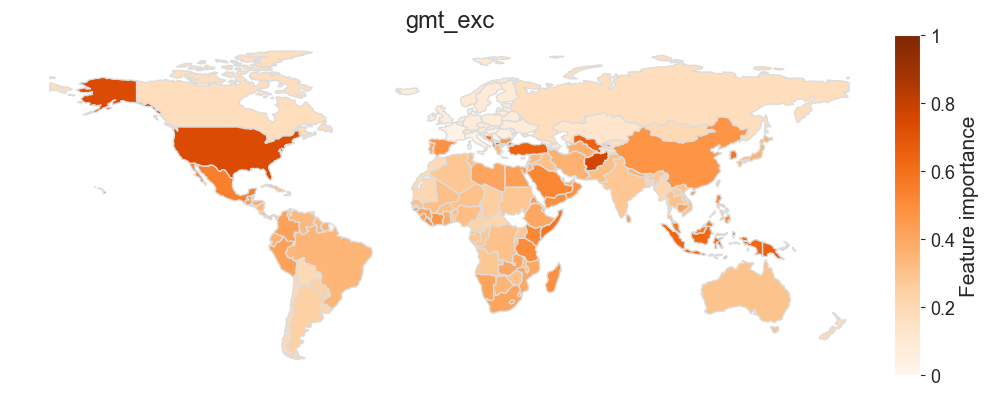

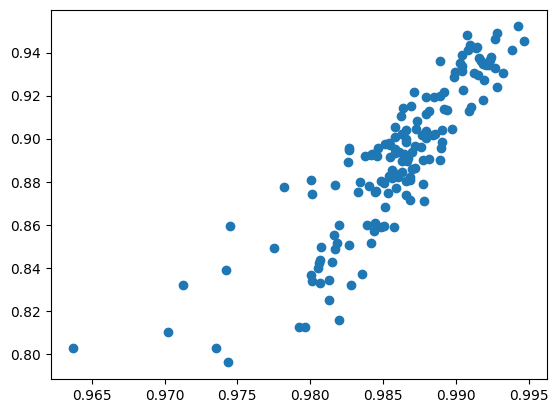

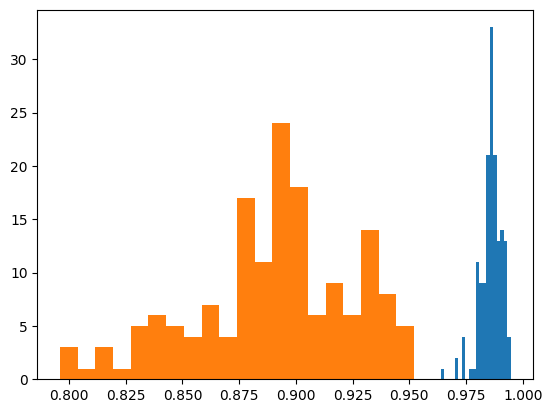

In [30]:
sel_predictors = ['tas_soc', 'gmt_eoc', 'gmt_exc']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries, dtype = float) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


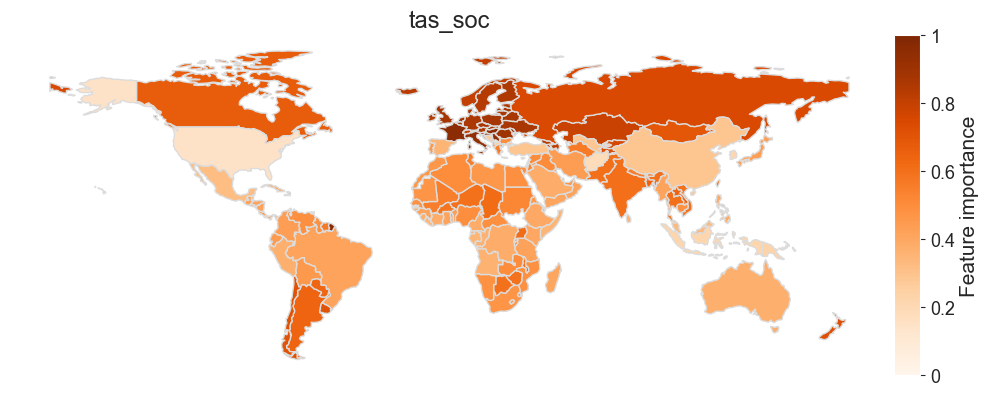

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


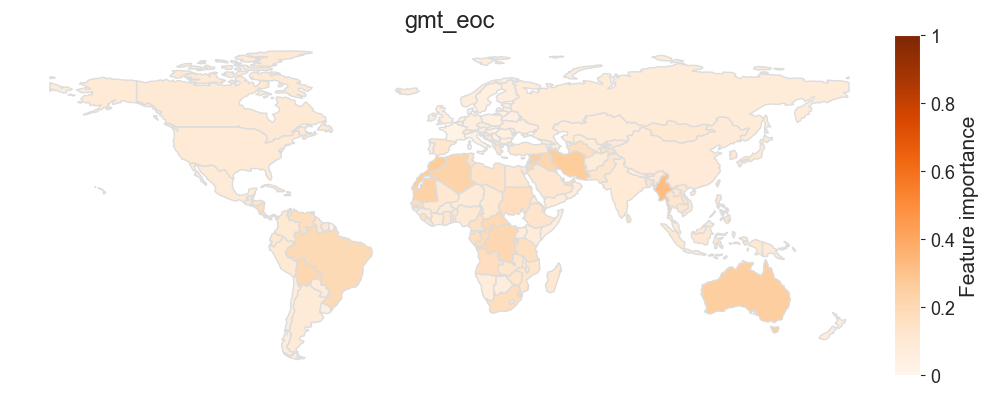

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


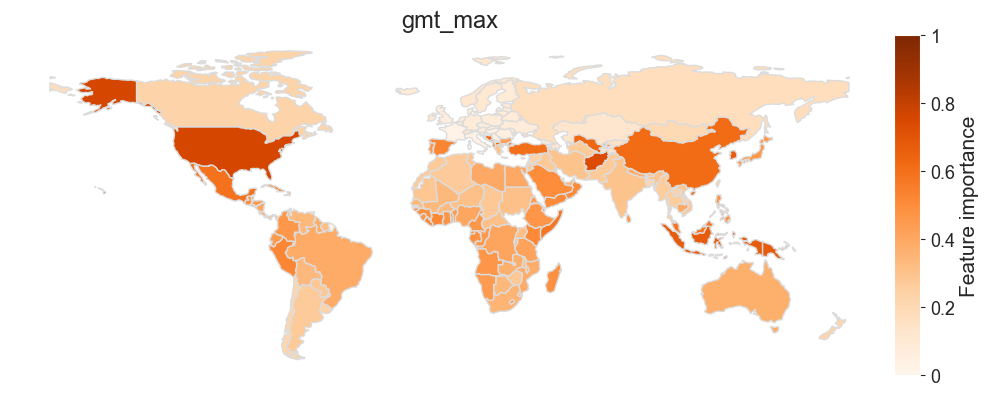

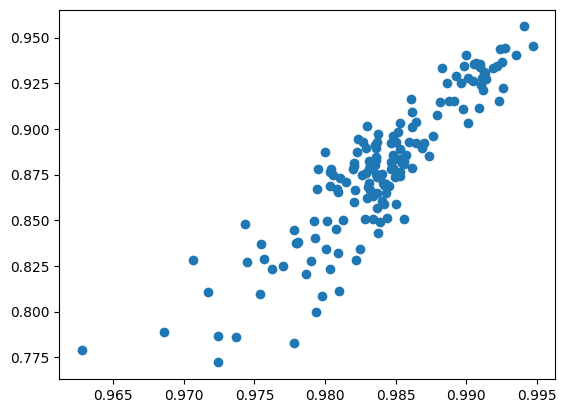

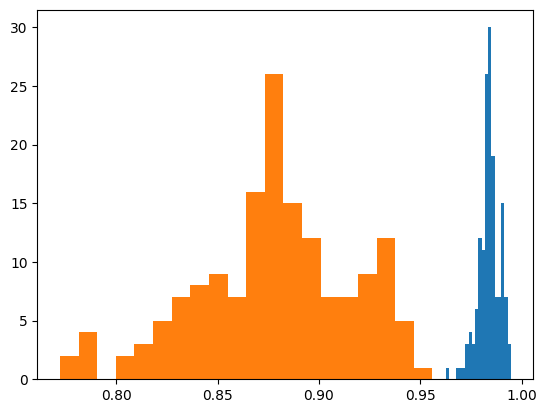

In [22]:
sel_predictors = ['tas_soc', 'gmt_eoc', 'gmt_max']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


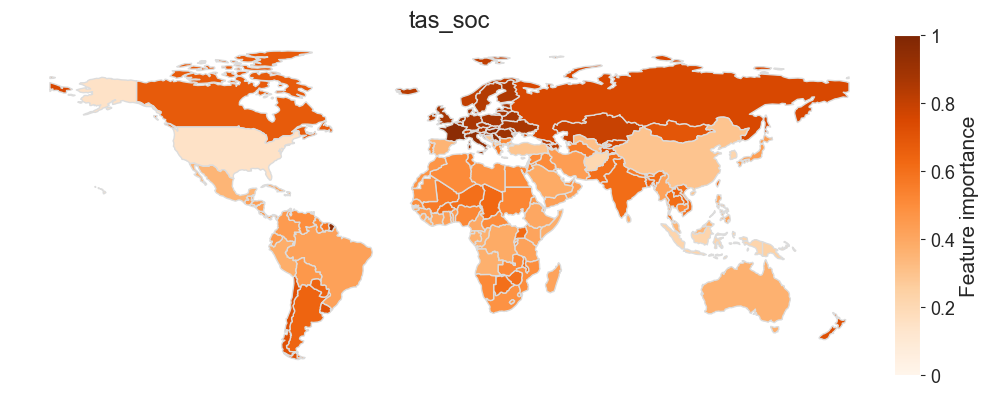

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


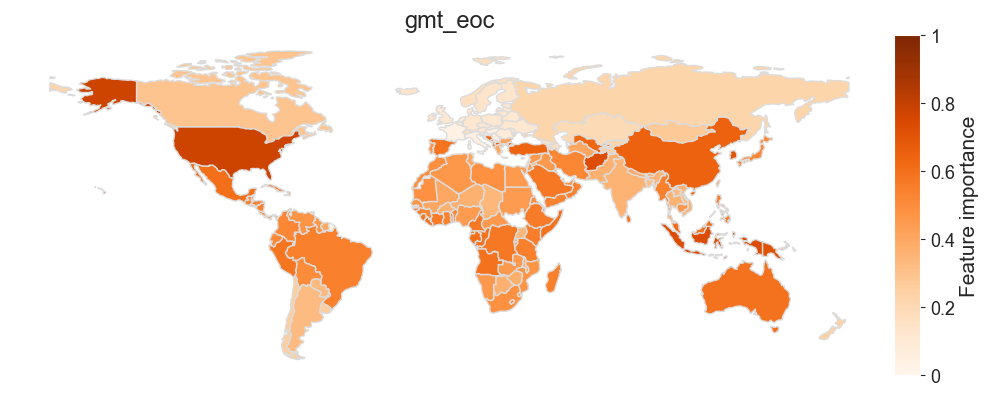

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


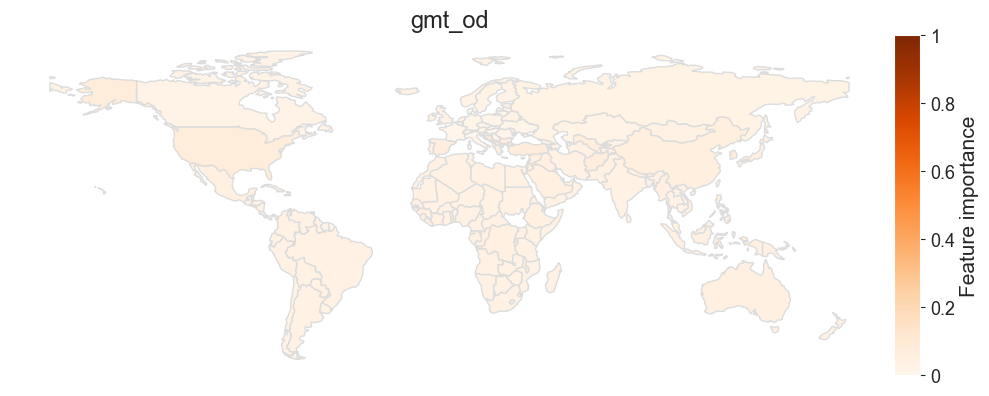

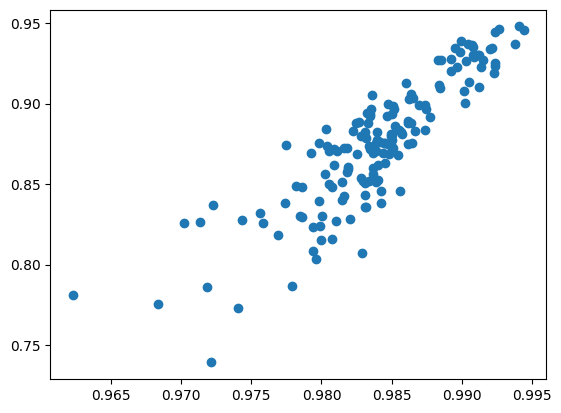

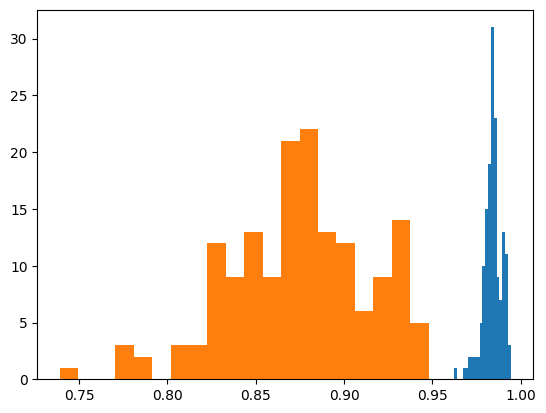

In [20]:
sel_predictors = ['tas_soc', 'gmt_eoc', 'gmt_od']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


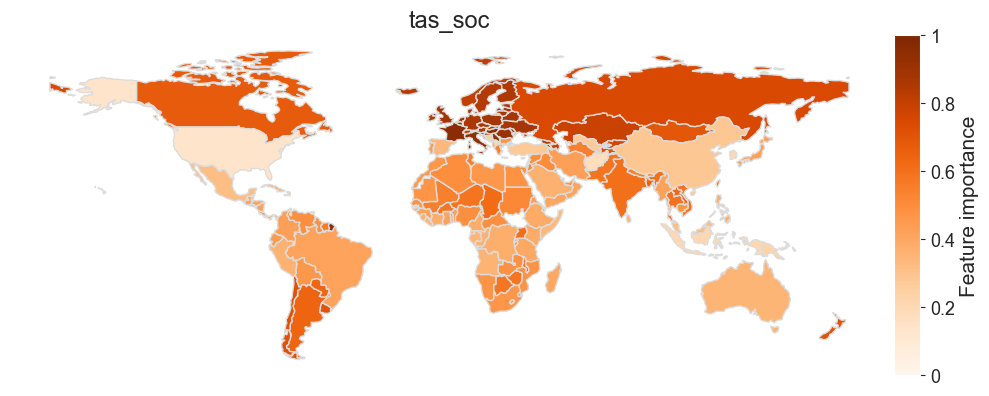

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


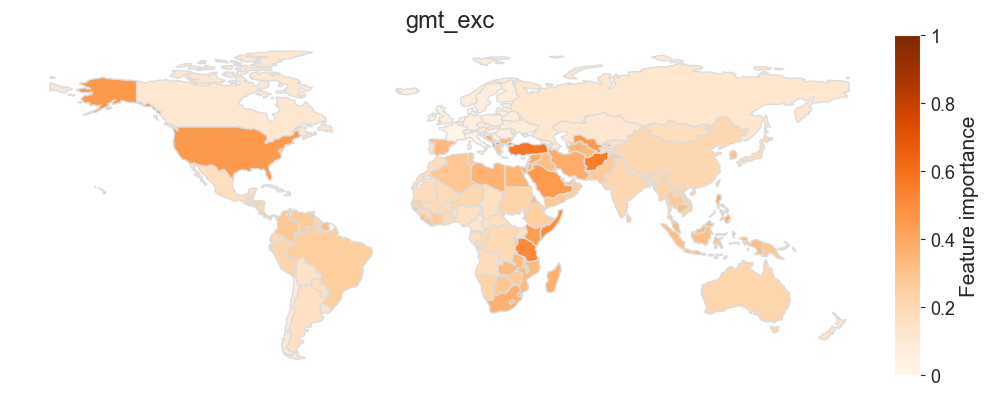

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


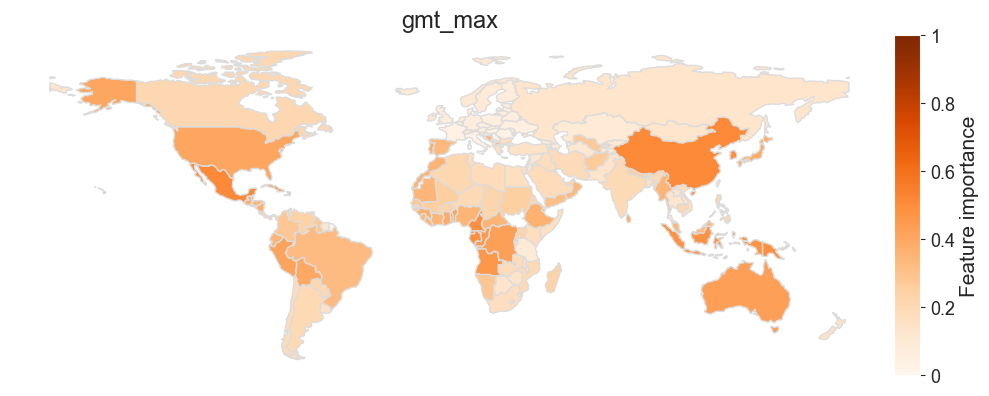

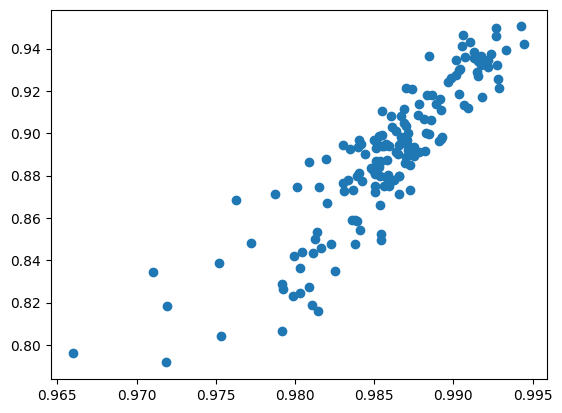

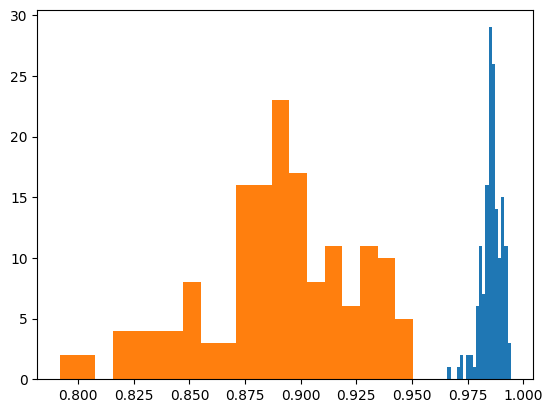

In [29]:
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_max']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_
    
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


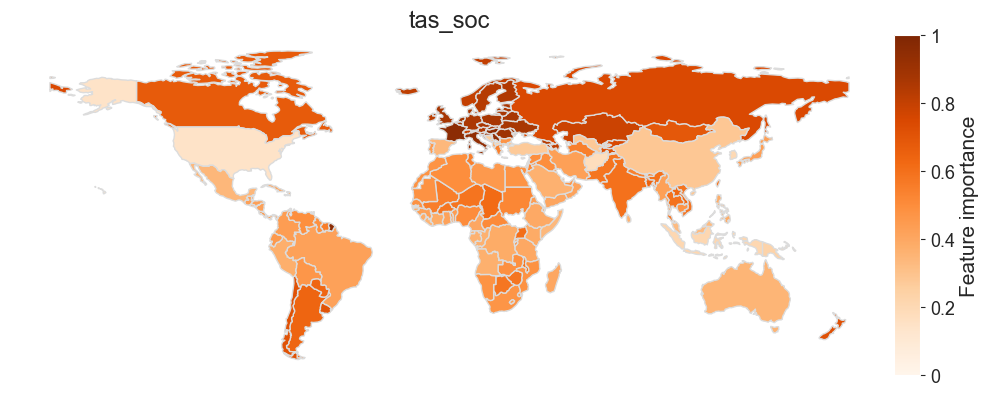

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


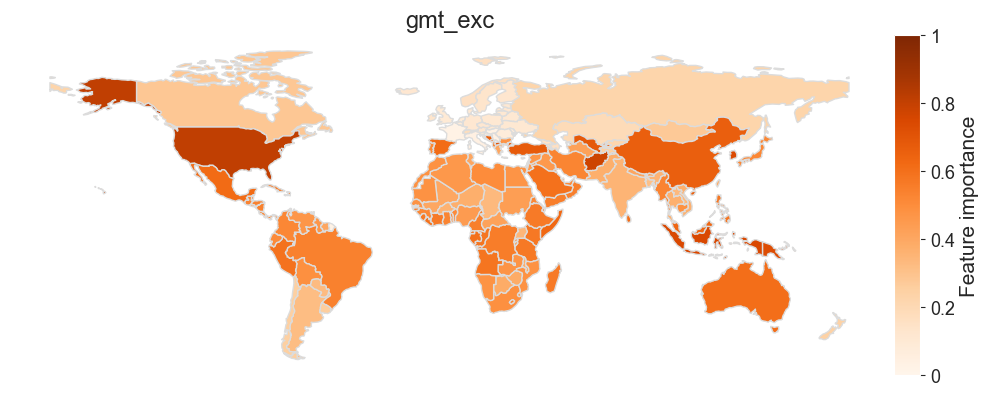

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


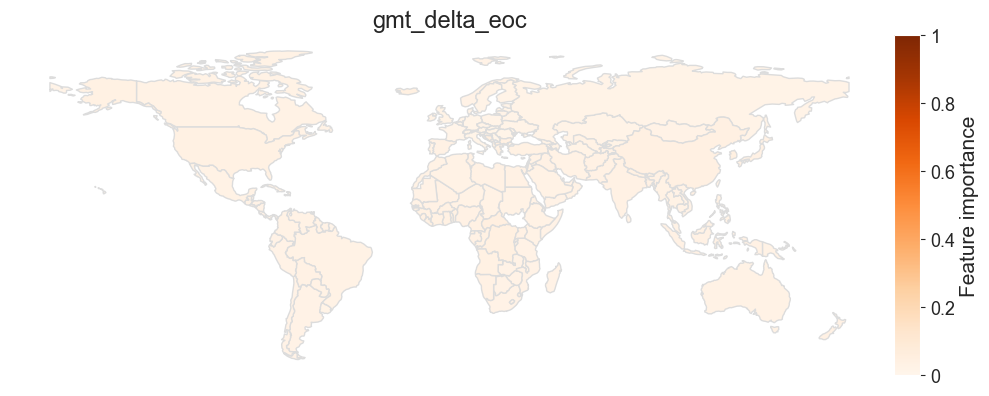

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


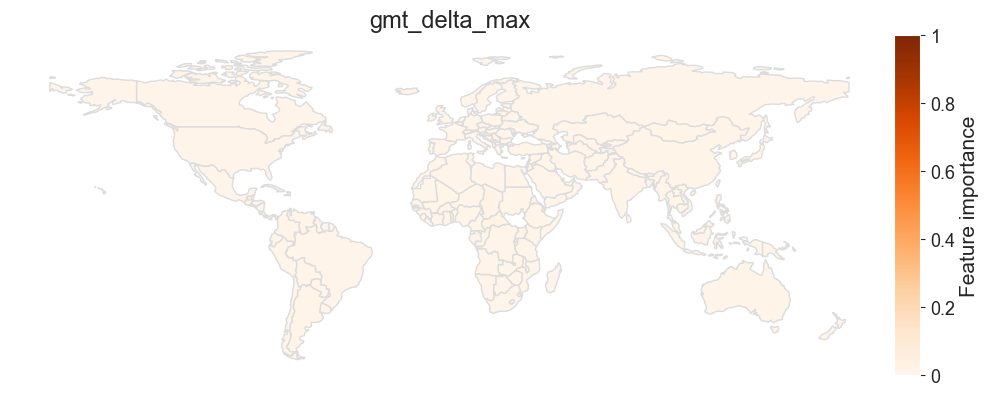

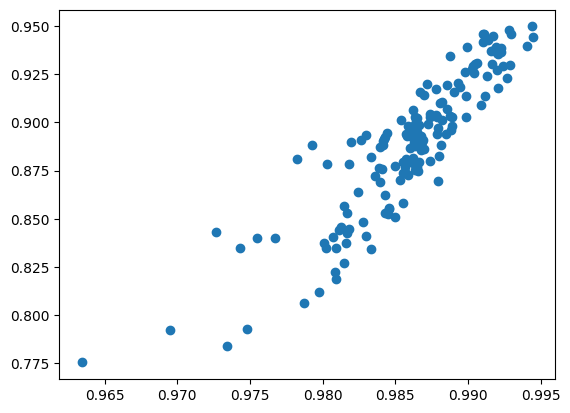

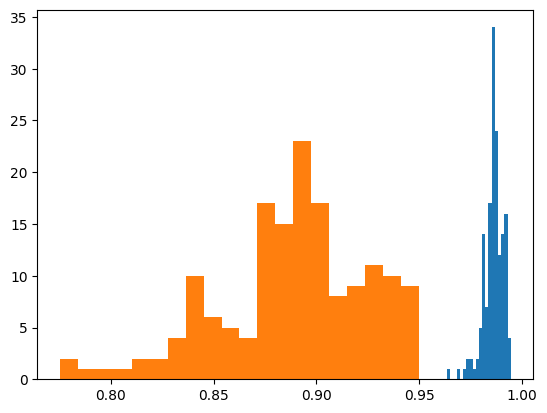

In [58]:
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_delta_eoc', 'gmt_delta_max']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_
    
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


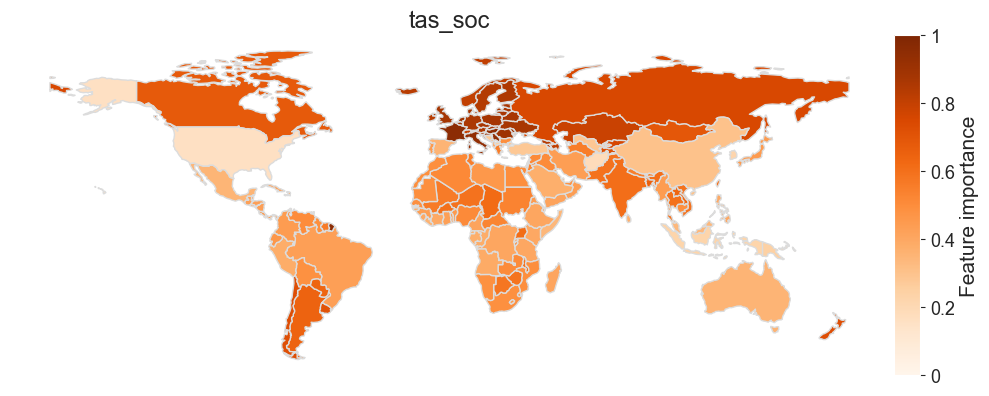

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


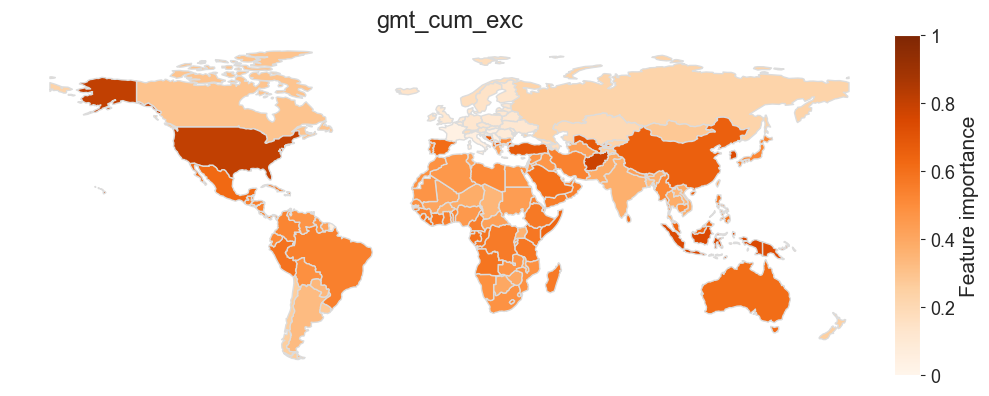

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


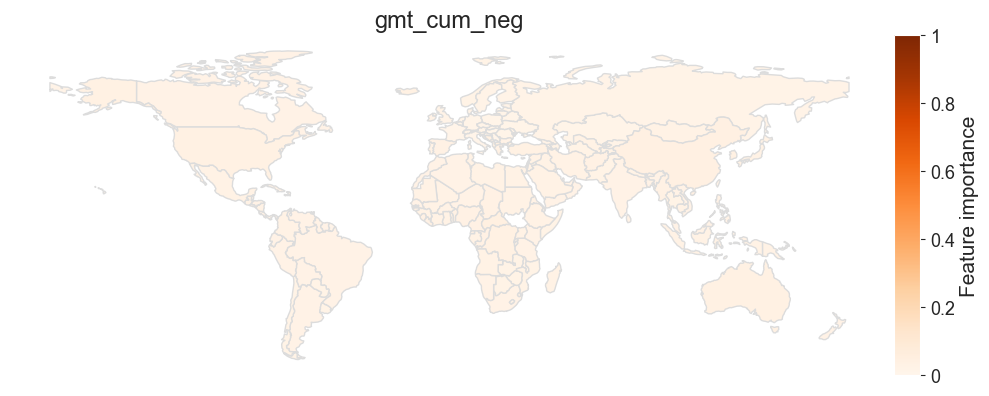

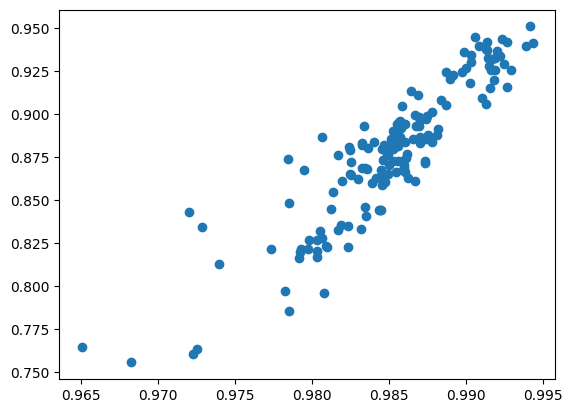

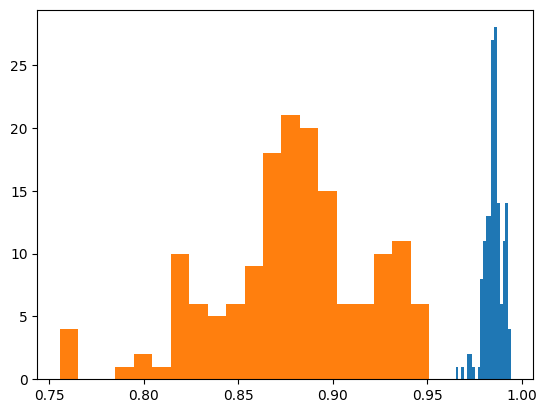

In [7]:
sel_predictors = ['tas_soc', 'gmt_cum_exc', 'gmt_cum_neg']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


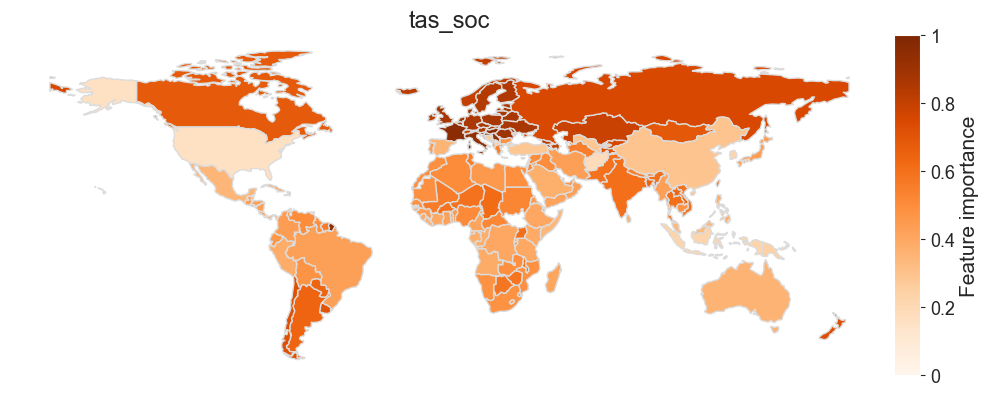

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


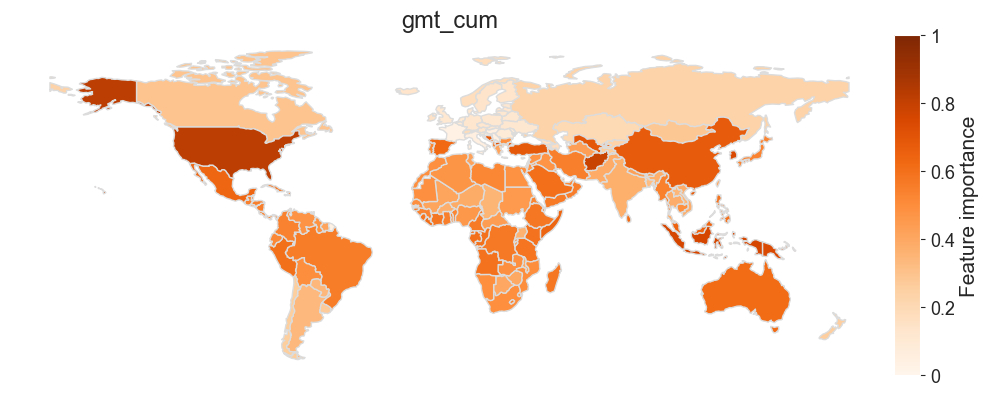

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


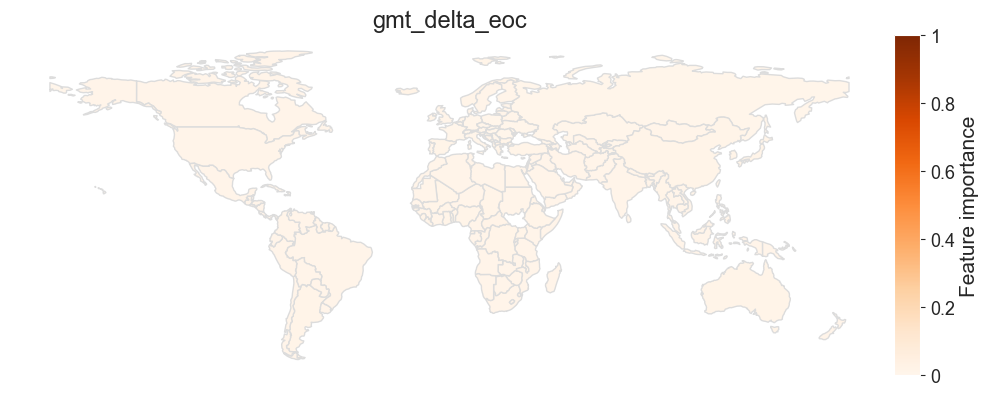

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


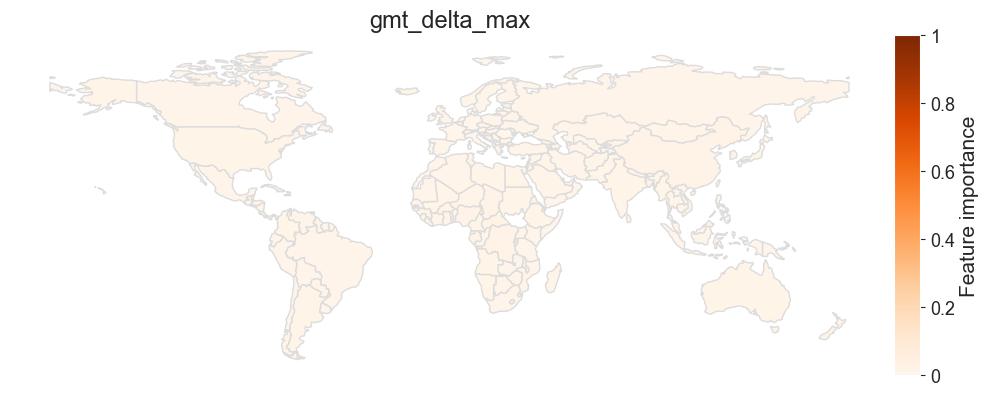

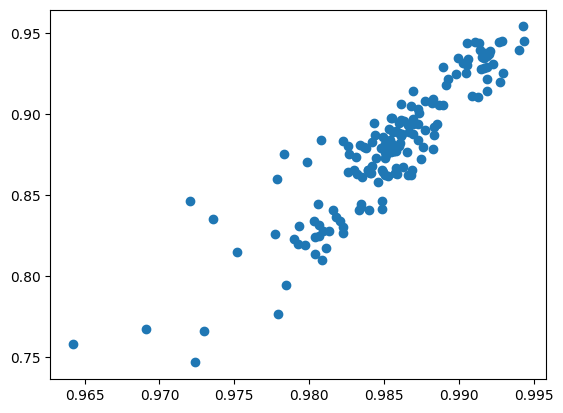

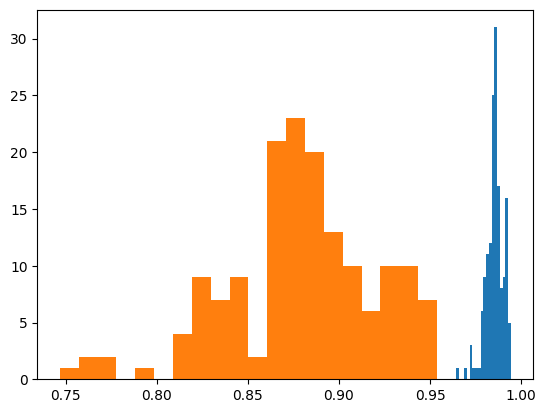

In [22]:
sel_predictors = ['tas_soc', 'gmt_cum', 'gmt_delta_eoc', 'gmt_delta_max']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

scores = np.zeros((n_countries, 2))

i_country = 0
for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    scores[i_country, 0] = rf.score(X_train,y_train)
    scores[i_country, 1] = rf.score(X_test, y_test)
    i_country += 1
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

plt.figure()
plt.scatter(scores[:,0], scores[:,1])
plt.show()

plt.figure()
plt.hist(scores[:,0], bins = 20)
plt.hist(scores[:,1], bins = 20)
plt.show()

#### c: Hyper-parameter tuning 

#### d: distribution of coefficients across models

In [13]:
predictor_df

tas_soc  tas_baseline   gmt_cum   gmt_max   gmt_eoc    gmt_os  \
0       1.261309     -0.770121  1.322797  1.959981  2.062101 -0.913158   
1       2.537376     -0.770121  0.035834  0.743271  0.903613 -0.913158   
2       1.563342     -0.770121  1.418064  2.135664  2.229378 -0.913158   
3      -0.124967     -0.770121  0.035834  0.743271  0.903613 -0.913158   
4       0.928253     -0.770121  0.302739  1.056668  1.202014 -0.913158   
...          ...           ...       ...       ...       ...       ...   
156995 -0.399567      0.300891  0.535571  0.454149  0.008263  1.977042   
156996 -0.486344      0.300891  0.448301  0.348646 -0.075301  1.898312   
156997  1.568238      0.300891  0.448301  0.348646 -0.075301  1.898312   
156998  0.364299      0.300891  1.718645  1.276856  1.147342  0.318889   
156999  0.164998      0.300891  1.224103  0.919732  0.437492  2.042650   

          gmt_od  gmt_cum_exc  gmt_cum_neg  tas_soc^2  ...  gmt_os^2  \
0      -0.914268     1.246814    -0.960691   0.293608  ... -0.598241   
1      -0.914268    -0.063912    -0.960691   2.702187  ... -0.598241   
2      -0.914268     1.343841    -0.960691   0.717518  ... -0.598241   
3      -0.914268    -0.063912    -0.960691  -0.489123  ... -0.598241   
4      -0.914268     0.207921    -0.960691  -0.068742  ... -0.598241   
...          ...          ...          ...        ...  ...       ...   
156995  1.653381     0.690891     1.391470  -0.417554  ...  2.126758   
156996  1.612552     0.608338     1.452022  -0.379355  ...  1.980321   
156997  1.612552     0.608338     1.452022   0.725136  ...  1.980321   
156998  0.024376     1.730434    -0.190843  -0.430940  ... -0.103059   
156999  1.686623     1.385857     1.331386  -0.483356  ...  2.251878   

        gmt_os gmt_od  gmt_os gmt_cum_exc  gmt_os gmt_cum_neg  gmt_od^2  \
0           -0.629826           -0.781657           -0.672047 -0.654077   
1           -0.629826           -0.781657           -0.672047 -0.654077   
2           -0.629826           -0.781657           -0.672047 -0.654077   
3           -0.629826           -0.781657           -0.672047 -0.654077   
4           -0.629826           -0.781657           -0.672047 -0.654077   
...               ...                 ...                 ...       ...   
156995       1.941184            2.038661            1.851345  1.694768   
156996       1.831380            1.917697            1.845797  1.620662   
156997       1.831380            1.917697            1.845797  1.620662   
156998      -0.229172            0.664169           -0.319983 -0.340181   
156999       2.033586            2.493337            1.842705  1.755979   

        gmt_od gmt_cum_exc  gmt_od gmt_cum_neg  gmt_cum_exc^2  \
0                -0.813366           -0.690191       1.193962   
1                -0.813366           -0.690191      -0.160553   
2                -0.813366           -0.690191       1.308255   
3                -0.813366           -0.690191      -0.160553   
4                -0.813366           -0.690191       0.091362   
...                    ...                 ...            ...   
156995            1.839768            1.601920       0.576377   
156996            1.755574            1.623539       0.490080   
156997            1.755574            1.623539       0.490080   
156998            0.353023           -0.415946       1.782849   
156999            2.238108            1.572286       1.358349   

        gmt_cum_exc gmt_cum_neg  gmt_cum_neg^2  
0                     -0.886678      -0.706664  
1                     -0.886678      -0.706664  
2                     -0.886678      -0.706664  
3                     -0.886678      -0.706664  
4                     -0.886678      -0.706664  
...                         ...            ...  
156995                 1.698445       1.326556  
156996                 1.722333       1.432586  
156997                 1.722333       1.432586  
156998                 0.130830      -0.488863  
156999                 1.973595   

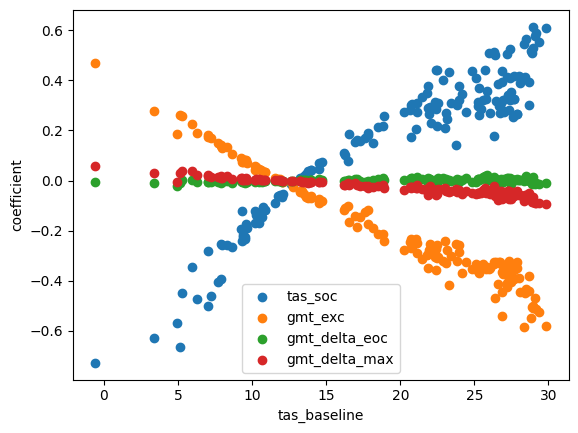

In [23]:
predictor_sets = [['tas_soc', 'gmt_cum', 'gmt_eoc'],
                  ['tas_soc', 'log_gmt_cum', 'gmt_eoc'],
                  ['tas_soc', 'gmt_max', 'gmt_eoc'],
                  ['tas_soc', 'gmt_max', 'gmt_cum', 'gmt_eoc'],
                   ['tas_soc', 'gmt_max', 'gmt_cum', 'gmt_eoc', 'gmt_soc']
                  ]

predictor_sets = [['tas_soc', 'gmt_exc', 'gmt_delta_eoc', 'gmt_delta_max']
                  ]

for sel_predictors in predictor_sets:
    coefficients = np.zeros((len(np.unique(regression_df['iso'])), len(sel_predictors)+1))
    tas_baselines    = []
    gdp_baselines    = []
    i_iso = 0 
    for iso in np.unique(regression_df['iso']): 
        # subset data for the country 
        country_data  = regression_df[regression_df['iso'] == iso]
        y_country     = np.log(country_data['diff_SSP2'].values)
        X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
        X_country     = np.c_[StandardScaler().fit_transform(X_country_raw), np.ones(len(y_country))]
        # X_country     = np.c_[X_country_raw, np.ones(len(y_country))]
        coefficients[i_iso, :] =  LinearRegression().fit(X_country, y_country).coef_
        tas_baselines.append(np.mean(country_data['tas_baseline']))
        gdp_baselines.append(np.mean(country_data['GDP_baseline']))
        i_iso += 1
    
    plt.figure()
    for i_pred in range(len(sel_predictors)):
        plt.scatter(tas_baselines, coefficients[:, i_pred], label = sel_predictors[i_pred])
        plt.xlabel('tas_baseline')
        plt.ylabel('coefficient')
    plt.legend()
    plt.show()